#  Time Series Prediction(LSTM)

In [1]:
#importing the required libraries
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import ccxt

### 1.Loading the financial data(web scraping)

In [2]:

# Initialize the Binance exchange
exchange = ccxt.binance()  # You can choose a different exchange if needed

# Specify the trading pair and timeframe
symbol = 'BTC/USDT'  # For BTC to USDT pair
timeframe = '1d'     # Daily timeframe

# Fetch OHLCV data with a specified limit
ohlcv = exchange.fetch_ohlcv(symbol, timeframe)


# Convert the data to a DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Display the DataFrame
print(df.head(10))

                open      high       low     close       volume
timestamp                                                      
2022-05-16  31328.89  31328.90  29087.04  29874.01  73082.19658
2022-05-17  29874.01  30788.37  29450.38  30444.93  56724.13307
2022-05-18  30444.93  30709.99  28654.47  28715.32  59749.15799
2022-05-19  28715.33  30545.18  28691.38  30319.23  67877.36415
2022-05-20  30319.22  30777.33  28730.00  29201.01  60517.25325
2022-05-21  29201.01  29656.18  28947.28  29445.06  20987.13124
2022-05-22  29445.07  30487.99  29255.11  30293.94  36158.98748
2022-05-23  30293.93  30670.51  28866.35  29109.15  63901.49932
2022-05-24  29109.14  29845.86  28669.00  29654.58  59442.96036
2022-05-25  29654.58  30223.74  29294.21  29542.15  59537.38659


### 2.Preparing the data(Data Pre-processing)

In [3]:
#removing unnecessary coloumns
df = df.reset_index()


In [4]:
df.head()

,timestamp,open,high,low,close,volume
0,2022-05-16,31328.89,31328.90,29087.04,29874.01,73082.19658
1,2022-05-17,29874.01,30788.37,29450.38,30444.93,56724.13307
2,2022-05-18,30444.93,30709.99,28654.47,28715.32,59749.15799
3,2022-05-19,28715.33,30545.18,28691.38,30319.23,67877.36415
4,2022-05-20,30319.22,30777.33,28730.00,29201.01,60517.25325


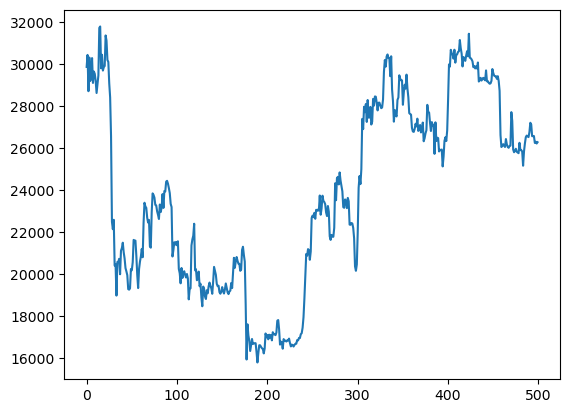

In [5]:
plt.plot(df.close)

In [6]:
df1 = df.reset_index()['close']

In [7]:
df1.shape

(500,)

In [8]:
df1

0      29874.01
1      30444.93
2      28715.32
3      30319.23
4      29201.01
         ...   
495    26575.96
496    26248.38
497    26304.81
498    26221.67
499    26282.99
Name: close, Length: 500, dtype: float64

### 3.Downscaling the data (MinMax scaler)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1.shape

(500, 1)

In [11]:
df1

array([[0.87970911],
       [0.91534762],
       [0.80738026],
       [0.90750105],
       [0.83769847],
       [0.85293279],
       [0.90592238],
       [0.83196429],
       [0.86601164],
       [0.85899343],
       [0.83771969],
       [0.80204185],
       [0.82710654],
       [0.85437101],
       [0.9958289 ],
       [1.        ],
       [0.87545311],
       [0.91582765],
       [0.86886   ],
       [0.87908675],
       [0.88253063],
       [0.97328672],
       [0.95782019],
       [0.90035612],
       [0.89443593],
       [0.83088625],
       [0.78923891],
       [0.67374584],
       [0.41861577],
       [0.39670532],
       [0.42462773],
       [0.28839526],
       [0.29260881],
       [0.19909799],
       [0.29917508],
       [0.29916821],
       [0.30850856],
       [0.26259461],
       [0.3326419 ],
       [0.34060457],
       [0.35642878],
       [0.3281437 ],
       [0.30969709],
       [0.28090326],
       [0.27102296],
       [0.25973689],
       [0.2183873 ],
       [0.216

### 4.Splitting the dataset into train and test split

In [12]:
training_size = int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(325, 175)

In [14]:
#converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[ i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 5.LSTM model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM 

In [20]:
model = Sequential()
model.add(LSTM(units = 50,activation = 'tanh', return_sequences = True,
              input_shape = (100,1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60,activation = 'tanh', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80,activation = 'tanh'))
model.add(Dropout(0.5))


model.add(Dense(units = 1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 80)                45120     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [22]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
4/4 [==============================] - 4s 290ms/step - loss: 0.0803 - val_loss: 0.0087
Epoch 2/100
4/4 [==============================] - 0s 118ms/step - loss: 0.0353 - val_loss: 0.0050
Epoch 3/100
4/4 [==============================] - 0s 126ms/step - loss: 0.0224 - val_loss: 0.0727
Epoch 4/100
4/4 [==============================] - 1s 133ms/step - loss: 0.0255 - val_loss: 0.0235
Epoch 5/100
4/4 [==============================] - 1s 133ms/step - loss: 0.0180 - val_loss: 0.0059
Epoch 6/100
4/4 [==============================] - 1s 130ms/step - loss: 0.0201 - val_loss: 0.0035
Epoch 7/100
4/4 [==============================] - 1s 131ms/step - loss: 0.0179 - val_loss: 0.0127
Epoch 8/100
4/4 [==============================] - 1s 131ms/step - loss: 0.0137 - val_loss: 0.0033
Epoch 9/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0140 - val_loss: 0.0095
Epoch 10/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0157 - val_loss: 0.0046
Epoch 11/

4/4 [==============================] - 1s 130ms/step - loss: 0.0064 - val_loss: 0.0039
Epoch 84/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 85/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0066 - val_loss: 0.0017
Epoch 86/100
4/4 [==============================] - 1s 126ms/step - loss: 0.0059 - val_loss: 0.0019
Epoch 87/100
4/4 [==============================] - 1s 128ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 88/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 89/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 90/100
4/4 [==============================] - 1s 128ms/step - loss: 0.0059 - val_loss: 0.0030
Epoch 91/100
4/4 [==============================] - 1s 127ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 92/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 93/100


### 6.Tesing our model on testdata

In [23]:
#Prediction and Performance Matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 [==============================] - 1s 14ms/step


In [24]:
#Upscaling the data
#back to orirginal form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
# RMSE performance metrics for training dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

997.1973557841283

In [26]:
# RMSE for test data
math.sqrt(mean_squared_error(y_test,test_predict))

736.1145034606928

In [27]:
test_predict

array([[30952.508],
       [30966.309],
       [30870.219],
       [30710.775],
       [30504.102],
       [30310.967],
       [30153.264],
       [30063.904],
       [30024.72 ],
       [30064.738],
       [30022.025],
       [29907.81 ],
       [29784.018],
       [29667.59 ],
       [29590.707],
       [29562.6  ],
       [29560.703],
       [29562.293],
       [29627.764],
       [29658.928],
       [29641.16 ],
       [29575.816],
       [29481.34 ],
       [29386.398],
       [29327.514],
       [29388.588],
       [29508.184],
       [29614.635],
       [29673.797],
       [29684.502],
       [29642.268],
       [29589.098],
       [29511.574],
       [29359.715],
       [28877.71 ],
       [28131.2  ],
       [27339.547],
       [26687.777],
       [26255.377],
       [26043.074],
       [26059.969],
       [26203.54 ],
       [26374.037],
       [26507.758],
       [26590.455],
       [26621.584],
       [26815.967],
       [27084.781],
       [27155.273],
       [26992.021],


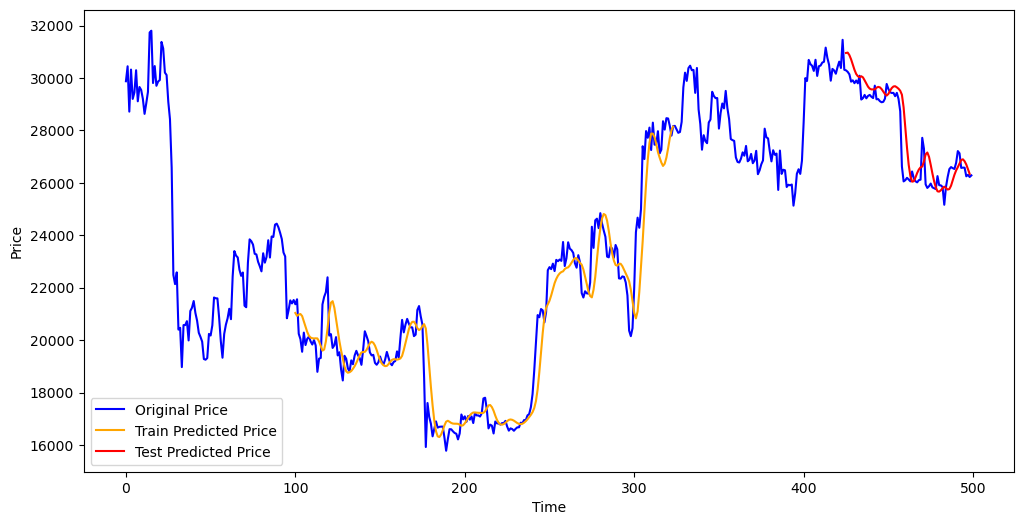

In [28]:
# Plotting 
plt.figure(figsize=(12,6)) 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(df1),'b',label ='Original Price')
plt.plot(trainPredictPlot,'orange',label ='Train Predicted Price')
plt.plot(testPredictPlot,'r',label='Test Predicted Price')
plt.legend()
plt.show()

### 7.Predicting future 30 days price

In [29]:
tlen=len(test_data)
tlen

175

In [30]:
x_input=test_data[tlen-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
#storing data collected into list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
temp_input

[0.7819535261162005,
 0.8871923719159163,
 0.8803901434167198,
 0.9305519749059754,
 0.9204975108850013,
 0.9164543766288489,
 0.9043025015995882,
 0.9307979213158757,
 0.8924059364222288,
 0.9154961843973846,
 0.9170374069507952,
 0.9241473805771003,
 0.9260906069070991,
 0.9597471870659655,
 0.9354215889761075,
 0.9190855038312085,
 0.8810462085862765,
 0.9090909658390425,
 0.9053412194322634,
 0.8976057678802727,
 0.913265188283213,
 0.9264070912467424,
 0.9112944958566769,
 0.9783510978635748,
 0.9070503597122301,
 0.905646467641505,
 0.902055275519281,
 0.896188142761279,
 0.8787802556219668,
 0.8819063967914604,
 0.8750891867850623,
 0.8814388489208635,
 0.8747146491050111,
 0.8928016979041495,
 0.8361684795330764,
 0.8394400661683235,
 0.8471212097567065,
 0.8390574135052045,
 0.8447603739134506,
 0.8471798873265814,
 0.8426972955258354,
 0.8396485588102187,
 0.869220805568127,
 0.8367621217559575,
 0.8372384088390892,
 0.8322664211364099,
 0.8296533965885862,
 0.830670266389924

In [33]:
#logic for prediction
from numpy import array

lst_output=[]
n_steps = 100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else :
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        

print(lst_output)

[0.64325273]
101
1 day input [0.88719237 0.88039014 0.93055197 0.92049751 0.91645438 0.9043025
 0.93079792 0.89240594 0.91549618 0.91703741 0.92414738 0.92609061
 0.95974719 0.93542159 0.9190855  0.88104621 0.90909097 0.90534122
 0.89760577 0.91326519 0.92640709 0.9112945  0.9783511  0.90705036
 0.90564647 0.90205528 0.89618814 0.87878026 0.8819064  0.87508919
 0.88143885 0.87471465 0.8928017  0.83616848 0.83944007 0.84712121
 0.83905741 0.84476037 0.84717989 0.8426973  0.83964856 0.86922081
 0.83676212 0.83723841 0.83226642 0.8296534  0.83067027 0.83832582
 0.87324272 0.86148036 0.85360009 0.85174488 0.85200331 0.84411742
 0.85205075 0.83763542 0.80832847 0.67679708 0.64125283 0.64412491
 0.64974173 0.64580471 0.64137767 0.66489365 0.64912124 0.64162799
 0.63896628 0.64423477 0.64537274 0.74502099 0.7190312  0.6341853
 0.62571264 0.62973642 0.63608483 0.62702165 0.62490426 0.62289736
 0.65379984 0.63229514 0.6317402  0.62799482 0.58560402 0.62790056
 0.65173988 0.67051234 0.67533576 0

14 day output [[0.63888496]]
15 day input [0.9190855  0.88104621 0.90909097 0.90534122 0.89760577 0.91326519
 0.92640709 0.9112945  0.9783511  0.90705036 0.90564647 0.90205528
 0.89618814 0.87878026 0.8819064  0.87508919 0.88143885 0.87471465
 0.8928017  0.83616848 0.83944007 0.84712121 0.83905741 0.84476037
 0.84717989 0.8426973  0.83964856 0.86922081 0.83676212 0.83723841
 0.83226642 0.8296534  0.83067027 0.83832582 0.87324272 0.86148036
 0.85360009 0.85174488 0.85200331 0.84411742 0.85205075 0.83763542
 0.80832847 0.67679708 0.64125283 0.64412491 0.64974173 0.64580471
 0.64137767 0.66489365 0.64912124 0.64162799 0.63896628 0.64423477
 0.64537274 0.74502099 0.7190312  0.6341853  0.62571264 0.62973642
 0.63608483 0.62702165 0.62490426 0.62289736 0.65379984 0.63229514
 0.6317402  0.62799482 0.58560402 0.62790056 0.65173988 0.67051234
 0.67533576 0.67281824 0.67081072 0.68548011 0.71342998 0.7081078
 0.67334322 0.67409604 0.67383511 0.6533866  0.65690913 0.65171928
 0.65554706 0.6432527

28 day output [[0.6216359]]
29 day input [0.8819064  0.87508919 0.88143885 0.87471465 0.8928017  0.83616848
 0.83944007 0.84712121 0.83905741 0.84476037 0.84717989 0.8426973
 0.83964856 0.86922081 0.83676212 0.83723841 0.83226642 0.8296534
 0.83067027 0.83832582 0.87324272 0.86148036 0.85360009 0.85174488
 0.85200331 0.84411742 0.85205075 0.83763542 0.80832847 0.67679708
 0.64125283 0.64412491 0.64974173 0.64580471 0.64137767 0.66489365
 0.64912124 0.64162799 0.63896628 0.64423477 0.64537274 0.74502099
 0.7190312  0.6341853  0.62571264 0.62973642 0.63608483 0.62702165
 0.62490426 0.62289736 0.65379984 0.63229514 0.6317402  0.62799482
 0.58560402 0.62790056 0.65173988 0.67051234 0.67533576 0.67281824
 0.67081072 0.68548011 0.71342998 0.7081078  0.67334322 0.67409604
 0.67383511 0.6533866  0.65690913 0.65171928 0.65554706 0.64325273
 0.63934612 0.63684452 0.63528365 0.634426   0.63413751 0.63431144
 0.63483542 0.6355871  0.63644296 0.6372878  0.63802171 0.63856596
 0.63886487 0.63888496 

In [34]:
day_new=np.arange(1,101)
day_pred = np.arange(101,131)

In [35]:
datalen=len(df1)

<function matplotlib.pyplot.show(close=None, block=None)>

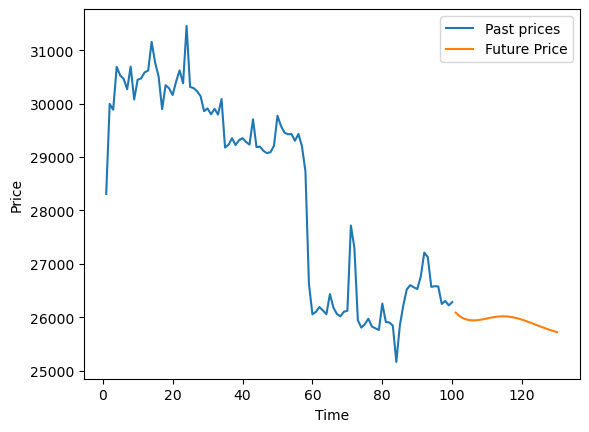

In [36]:
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(day_new,scaler.inverse_transform(df1[datalen-100:]),label='Past prices')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Future Price')
plt.legend()
plt.show